In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Download data

### Guadalajara hexagons

In [15]:
schema = 'hexgrid'
folder = 'hexgrid_9_city_2020'
city = 'Queretaro'
type_area = 'urban'

query = f"SELECT * FROM {schema}.{folder} WHERE \"city\" = \'{city}\' AND \"type\" = \'{type_area}\'"

hex_gdf = aup.gdf_from_query(query)
print(hex_gdf.shape)
hex_gdf.head(2)

(2826, 6)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type
0,894983d8997ffff,"POLYGON ((-100.45238 20.55939, -100.45114 20.5...",22006,Corregidora,Queretaro,urban
1,894983c3697ffff,"POLYGON ((-100.47848 20.52605, -100.47723 20.5...",22006,Corregidora,Queretaro,urban


### Estructura urbana - Frente de manzana - Marco Geoestadístico

In [16]:
gdf_tmp = hex_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.set_geometry("geometry")
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [17]:
query = f"SELECT * FROM censo_urbano.censo_fm_2020 WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
entorno = aup.gdf_from_query(query, geometry_col='geometry')
print(entorno.shape)
entorno.head(4)

(85368, 68)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,ESTACIONBICI,ARBOLES,ALUMPUB,TELPUB,PUESTOSEMI,PUESTOAMBU,BANQUETA,GUARNICION,TAMLOC,VIANOESP
0,2201400011706001,22,014,0001,1706,001,05890,00004,1,Ramón López Velarde,...,3,3,3,3,3,1,1,1,10,0
1,2201400011706001,22,014,0001,1706,001,05886,00009,2,Sor Juana Inés de la Cruz,...,3,1,1,3,3,3,1,1,10,0
2,2201400011706001,22,014,0001,1706,001,05883,00002,3,Alfonso Reyes,...,3,1,1,1,3,3,1,1,10,0
3,2201400011706001,22,014,0001,1706,001,06260,00001,4,Salvador Novo,...,3,1,1,3,3,3,1,1,10,0


In [18]:
entorno.columns

Index(['CVEGEO2', 'CVE_ENT', 'CVE_MUN', 'CVE_LOC', 'CVE_AGEB', 'CVE_MZA',
       'CVEVIAL_x', 'CVESEG', 'CVEFT_x', 'NOMVIAL_x', 'TIPOVIAL', 'CVEVIAL1',
       'CVESEG1', 'CVEREF1', 'TIPOVR1', 'NOMREF1', 'CVEVIAL2', 'CVESEG2',
       'CVEREF2', 'TIPOVR2', 'NOMREF2', 'CVEVIAL3', 'CVESEG3', 'CVEREF3',
       'TIPOVR3', 'NOMREF3', 'geometry', 'CVEGEO', 'CVEGEOFTE', 'ID_FTE',
       'ID_MZA', 'ENT', 'MUN', 'LOC', 'AGEB', 'MZA', 'CVEFT_y', 'CVEVIAL_y',
       'NOMVIAL_y', 'NOMVIAL_C', 'TIPOVIAL_C', 'ESVIALIDAD', 'CLASEVIA',
       'CLASERASGO', 'OTRORASGO_C', 'RECUCALLE', 'RESTRICPEAT', 'RESTRICAUTO',
       'PASOPEAT', 'DRENAJEP', 'TRANSCOL', 'CICLOVIA', 'CICLOCARRIL',
       'LETRERO', 'RAMPAS', 'SEMAFOROPEAT', 'SEMAFOROAUDI', 'PARADATRANS',
       'ESTACIONBICI', 'ARBOLES', 'ALUMPUB', 'TELPUB', 'PUESTOSEMI',
       'PUESTOAMBU', 'BANQUETA', 'GUARNICION', 'TAMLOC', 'VIANOESP'],
      dtype='object')

## Urban structure analysis

In [19]:
ent_int = entorno.overlay(hex_gdf, how='intersection')
print(ent_int.shape)
ent_int.head(2)

(108382, 73)


,CVEGEO2,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,CVE_MZA,CVEVIAL_x,CVESEG,CVEFT_x,NOMVIAL_x,...,BANQUETA,GUARNICION,TAMLOC,VIANOESP,hex_id_9,CVEGEO_2,NOMGEO,city,type,geometry
0,2201400011706001,22,014,0001,1706,001,05890,00004,1,Ramón López Velarde,...,1,1,10,0,894983c12c7ffff,22014,Querétaro,Queretaro,urban,"LINESTRING (-100.43902 20.61174, -100.4376 20...."
1,2201400011706001,22,014,0001,1706,001,05886,00009,2,Sor Juana Inés de la Cruz,...,1,1,10,0,894983c12c7ffff,22014,Querétaro,Queretaro,urban,"LINESTRING (-100.4376 20.61206, -100.43731 20...."


In [20]:
ent_int['length'] = ent_int.to_crs("EPSG:32613").length

In [21]:
urban_elements = ['BANQUETA','ALUMPUB','RAMPAS','ARBOLES',
                     'CICLOVIA']

for col in urban_elements:
    ent_tmp = ent_int.loc[(ent_int[col]==1)][['hex_id_9','length']].groupby(['hex_id_9']).sum()
    ent_tot = ent_int.loc[(ent_int[col]==1)|(ent_int[col]==3)][['hex_id_9','length']].groupby(['hex_id_9']).sum().reset_index().rename(columns={'length':                                                                                    'length_'+col})
    ent_tmp = ent_tmp.merge(ent_tot, on='hex_id_9')
    ent_tmp['pct_'+col] = ent_tmp['length'] / ent_tmp['length_'+col]
    ent_tmp = ent_tmp.drop(columns=['length','length_'+col])

    hex_gdf = hex_gdf.merge(ent_tmp, on='hex_id_9', how='left')

In [22]:
hex_gdf = hex_gdf.fillna(0)

<Axes: >

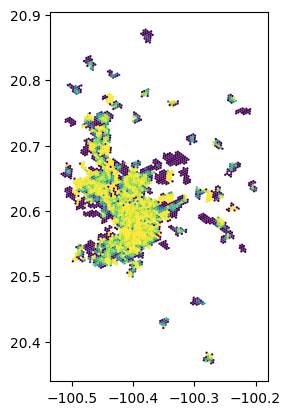

In [23]:
hex_gdf.plot('pct_BANQUETA')

<Axes: >

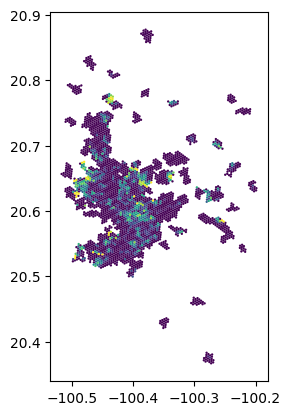

In [24]:
hex_gdf.plot('pct_RAMPAS')

<Axes: >

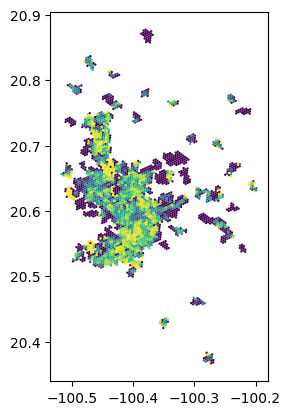

In [25]:
hex_gdf.plot('pct_ARBOLES')

<Axes: >

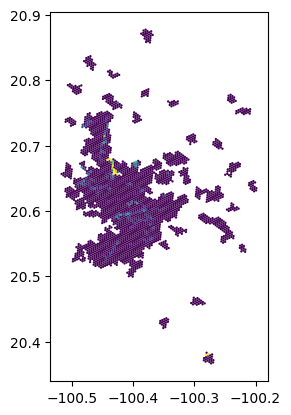

In [26]:
hex_gdf.plot('pct_CICLOVIA')

## Save data

In [28]:
hex_gdf.to_file('../../../data/processed/distrito_qro/hex_infraestructura_distrito_qro.geojson')